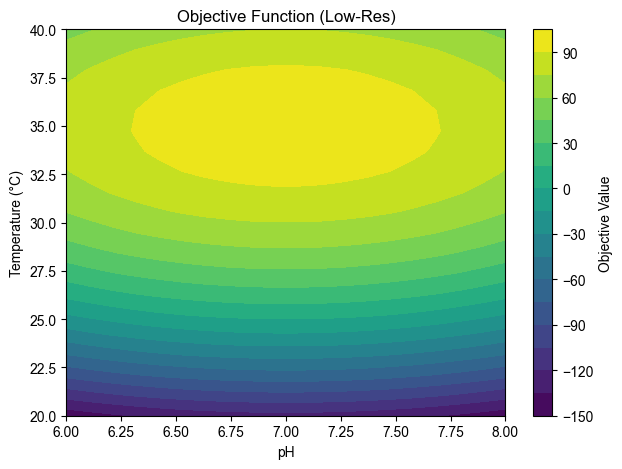

In [127]:
import torch
import matplotlib.pyplot as plt

bounds = torch.tensor([[6.0, 20.0], [8.0, 40.0]], dtype=torch.double)

def objective_function(X, pHopt=7, temp_opt=35, a=100, b=20, c=1):
    pH, temp = X[:, 0], X[:, 1]
    return a - b * (pH - pHopt)**2 - c * (temp - temp_opt)**2

ph_vals = torch.linspace(bounds[0, 0], bounds[1, 0], 20)
temp_vals = torch.linspace(bounds[0, 1], bounds[1, 1], 20)
PH, TEMP = torch.meshgrid(ph_vals, temp_vals, indexing='ij')
grid = torch.stack([PH.reshape(-1), TEMP.reshape(-1)], dim=-1)

Z = objective_function(grid).reshape(20, 20)

plt.contourf(PH.numpy(), TEMP.numpy(), Z.numpy(), levels=20, cmap='viridis')
plt.colorbar(label='Objective Value')
plt.xlabel('pH')
plt.ylabel('Temperature (°C)')
plt.title('Objective Function (Low-Res)')
plt.tight_layout()
plt.show()


In [168]:
#Bayesian Optimization using Gaussian Processes for Hyperparameter Tuning with noisy experimental data.

 
import torch
from torch.optim import Adam
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch import kernels, means, likelihoods
from gpytorch.priors import LogNormalPrior
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms import Standardize, Normalize
from botorch.utils.transforms import normalize, unnormalize

from pyDOE3 import lhs


import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline
%load_ext autoreload
%autoreload 2


seed= 0 # keeps inputs generated from lhs consistent across runs (also feeds into numpy)
# might want to set tensor random seed


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
# ===========================
# Config
# ===========================

# define ititial sample number
initial_sample = 24 # 24 is the aim for initial

# Define bounds for the parameters 
# careful with this as there's no checks to ensure bounds are realistic
# or that lower bounds is less than upper bounds.
bounds = torch.tensor([
    [6.0, 20.0],  # Lower bounds ph, temp
    [8.0, 40.0]   # Upper bounds ph, temp
], dtype=torch.double)

dim = bounds.shape[1]# Extracts number of dimensions from bounds variable


noise_level = 0.01 # this var is used in the fixed noise gp model to denote (0.1= 10%) noise in experimental output. It is also used in the objective function to add noise to the function


# standard Latin hypercube using maximin criterion (converts to tensor)
lhs_design = torch.tensor(
            lhs(n = dim, samples = initial_sample, criterion = 'maximin', random_state=seed), 
        dtype=torch.double
        )

# flexibly set the bounds using 'bounds' variable (allowing for dimensional scale-up)
scaled_lhs_design = bounds[0] + (bounds[1]-bounds[0])*lhs_design

#print(scaled_lhs_design)

# This is the black box function we want to converge to. Here we use a simple function so we can generate train_Y from initial dataset and also validate the convergence of the BO model
def objective_function(X, pHopt =7 , temp_opt =35, a = 100, b = 20, c = 1, noise_level = noise_level, seed = None):
    """
    Simulates a 2D Gaussian-like response surface with controllable noise.

    Parameters:
    - X: input tensor of shape [n, 2], columns are [pH, temp]
    - pHopt, temp_opt: optimal pH and temperature
    - a: peak value (must be high enough to keep output positive)
    - b, c: curvature coefficients (bigger = narrower peak)
    - noise_level: fraction of y to scale the noise (e.g., 0.1 = 10%)

    Returns:
    - y: simulated noisy response values
    """
    if seed is not None:
        torch.manual_seed(seed) # set for reproducibility
    pH, temp = X[:, 0], X[:, 1]
    y = a-b*(pH-pHopt)**2 - c*(temp-temp_opt)**2
    noise = noise_level * a * torch.randn_like(y) # changed this here from Isabella's to make noise homoscedastic (same for all points)
    return y + noise
'''
# generates initial sample using latinhypercube
g=torch.Generator().manual_seed(42) # ensure's results are same each time
train_X = maximin_lhs(initial_sample, bounds, generator=g) # this will be consistent as we set the seed at beginning
'''
# above is broken, below is temp fix
train_X = scaled_lhs_design
# generates solution for initial sample using objective function
train_Y= objective_function(train_X, seed=seed)
train_Y = train_Y.unsqueeze(-1) # reshape to (n, 1) (from (n,))



#print(train_X, train_Y)

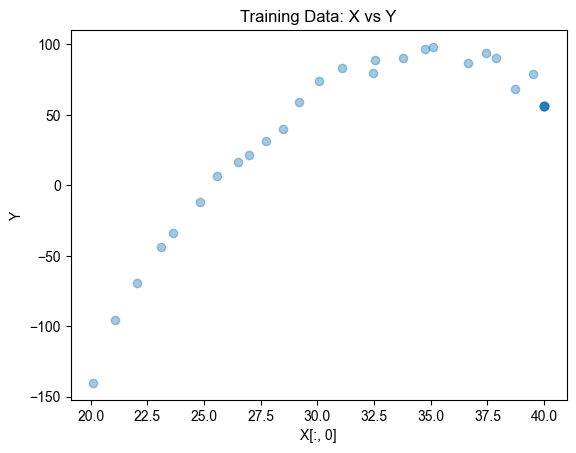

In [185]:
plt.scatter(train_X[:, 1], train_Y, alpha=0.4)
plt.title("Training Data: X vs Y")
plt.xlabel("X[:, 0]")
plt.ylabel("Y")
plt.show()


In [186]:
with torch.no_grad():
    model.eval()
    model.likelihood.eval()
    test_x = train_X  # we use training points
    posterior = model.posterior(test_x)
    pred_mean = posterior.mean
    pred_std = posterior.variance.sqrt()

    print(f"True Y (first 5):      {train_Y[:5].squeeze().numpy()}")
    print(f"Pred Mean (first 5):   {pred_mean[:5].squeeze().numpy()}")
    print(f"Pred Std Dev (first 5):{pred_std[:5].squeeze().numpy()}")


True Y (first 5):      [16.8491629   6.6491633  90.5998863  90.1482092  86.85133248]
Pred Mean (first 5):   [17.0074454   6.35445003 90.75752883 90.30240973 86.83327946]
Pred Std Dev (first 5):[0.35644956 0.34212435 0.33382468 0.36167871 0.35012907]


In [178]:
# ===========================
# Setup (Assume train_X, train_Y, bounds, and objective_function are defined)
# ===========================

#Matern model  (dim is a variable extracted from bounds and denotes number of input dimensions)
class GPModel(SingleTaskGP):
    def __init__(self, train_X, train_Y, fixed_noise=False, noise_level=noise_level,
                 lengthscale_prior=None, outputscale_prior=None):
        
        if fixed_noise: # we can fix the noise in the y output which will allow the model to converge faster assuming amount of data is quite minimal
            print(f"Training with FIXED noise: {noise_level*100:.1f}% of mean output.")
            noise_variance = (noise_level * train_Y.mean()).pow(2)
            train_Yvar = torch.full_like(train_Y, noise_variance)
            likelihood = None # SingleTaskGP handles internally
            super().__init__(
                train_X, train_Y, train_Yvar=train_Yvar, likelihood=likelihood,
                outcome_transform=Standardize(m=1),
                input_transform=Normalize(d=dim)
            )
        else:
            print("Training with LEARNABLE noise (Gaussian Likelihood).")
            likelihood = likelihoods.GaussianLikelihood() # in this case noise is not fixed and we will use Gaussian assumptions to learn the noise
            super().__init__(
                train_X, train_Y, likelihood=likelihood,
                outcome_transform = Standardize(m=1),
                input_transform=Normalize(d=dim) 
            )
        self.mean_module = means.ConstantMean() # Mean function

        # matern kernel with ARD (lengthscale for each input dimension is assumed different)
        matern_kernel = kernels.MaternKernel(nu=5/2, ard_num_dims=dim)
        if lengthscale_prior is not None:
            matern_kernel.lengthscale_prior = lengthscale_prior
        
        self.covar_module = kernels.ScaleKernel(base_kernel=matern_kernel, outputscale_prior=outputscale_prior)

def train_GP_model(train_X, train_Y, fixed_noise = False, noise_level =noise_level, lengthscale_prior=None, outputscale_prior=None): 
    model = GPModel(train_X, train_Y, fixed_noise=fixed_noise, noise_level =noise_level, lengthscale_prior=lengthscale_prior, outputscale_prior=outputscale_prior)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
  
    fit_gpytorch_mll(mll)
    return model, mll

Below, train_GP_model, is now designed to return model, mll, so YOU need to fix it (example is in
last line 'model_prior, _' so that it unpacks both) Or else it will cause problems later.

In [172]:
# Train with fixed noise (10%)
model_fixed = train_GP_model(train_X, train_Y, fixed_noise=True, noise_level=noise_level)

# Train with learned noise
model_learn = train_GP_model(train_X, train_Y, fixed_noise=False)

# We can also train model with priors
length_scale_prior = LogNormalPrior(0.0, 0.5) # deafult argument values; controls how quickly function varies (small=wiggly, large=smooth)
output_scale_prior = LogNormalPrior(0.0, 1.0) # default argument values; controls vertical scale of y (large = large variance, small = flatter function)
model_prior, _ = train_GP_model(train_X, train_Y, fixed_noise=False, lengthscale_prior=length_scale_prior, outputscale_prior=output_scale_prior)

Training with FIXED noise: 1.0% of mean output.
Training with LEARNABLE noise (Gaussian Likelihood).
Training with LEARNABLE noise (Gaussian Likelihood).


In [173]:
def plot_acquisition(acq_func, bounds, title="Acquisition Function"):
    # Create a grid over the raw input space
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], 100)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], 100)
    X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
    X_raw = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

    # Normalize input to match model expectations
    X = normalize(X_raw, bounds)

    # Evaluate acquisition function
    with torch.no_grad():
        acq_values = acq_func(X.unsqueeze(1)).squeeze(-1).cpu()

    # Reshape for heatmap
    Z = acq_values.reshape(100, 100)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.contourf(X1.numpy(), X2.numpy(), Z.numpy(), levels=50, cmap="viridis")
    plt.colorbar(label="Acquisition Value")
    plt.xlabel("X1 (raw)")
    plt.ylabel("X2 (raw)")
    plt.title(title)
    plt.tight_layout()
    plt.show()
import matplotlib.pyplot as plt
from matplotlib import cm
from botorch.utils.transforms import normalize
import torch

def plot_gp_surface(model, bounds, grid_size=50, plot_type="mean", title=None):
    """
    Plots the posterior mean or standard deviation (uncertainty) of a 2D GP model.

    Parameters:
    - model: trained GP model
    - bounds: tensor of shape [2, d] with original (unnormalized) input bounds
    - grid_size: number of grid points per dimension
    - plot_type: "mean" or "std"
    - title: optional title for the plot
    """
    pH_range = torch.linspace(bounds[0, 0], bounds[1, 0], grid_size)
    temp_range = torch.linspace(bounds[0, 1], bounds[1, 1], grid_size)
    mesh_pH, mesh_temp = torch.meshgrid(pH_range, temp_range, indexing='ij')
    
    X_grid = torch.stack([mesh_pH.reshape(-1), mesh_temp.reshape(-1)], dim=-1)
    X_normalized = normalize(X_grid, bounds=bounds)
    
    with torch.no_grad():
        posterior = model.posterior(X_normalized)
        if plot_type == "mean":
            Z = posterior.mean.reshape(grid_size, grid_size).cpu()
        elif plot_type == "std":
            Z = posterior.variance.sqrt().reshape(grid_size, grid_size).cpu()
        else:
            raise ValueError("plot_type must be 'mean' or 'std'")

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(mesh_pH.numpy(), mesh_temp.numpy(), Z.numpy(), cmap=cm.viridis)
    ax.set_xlabel("pH")
    ax.set_ylabel("Temperature")
    ax.set_zlabel(plot_type)
    ax.set_title(title or f"GP Posterior {plot_type.capitalize()} Surface")
    plt.tight_layout()
    plt.show()


In [174]:
from botorch.acquisition import UpperConfidenceBound, LogExpectedImprovement, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.acquisition.monte_carlo import qExpectedImprovement, qUpperConfidenceBound, qProbabilityOfImprovement
from botorch.acquisition.logei import qLogNoisyExpectedImprovement
from botorch.models.transforms.outcome import Standardize

Training with FIXED noise: 1.0% of mean output.
Candidates (normalized): tensor([[0., 1.]], dtype=torch.float64)
Candidates (raw): tensor([[ 6., 40.]], dtype=torch.float64)
Iteration 1:
  Candidate (raw): tensor([[ 6., 40.]], dtype=torch.float64)
  Predicted mean: -287.3978
  Predicted std:  205.4161
  New y:          56.5410


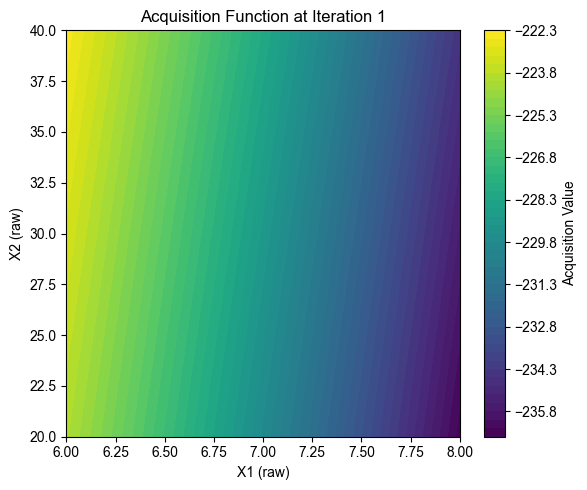

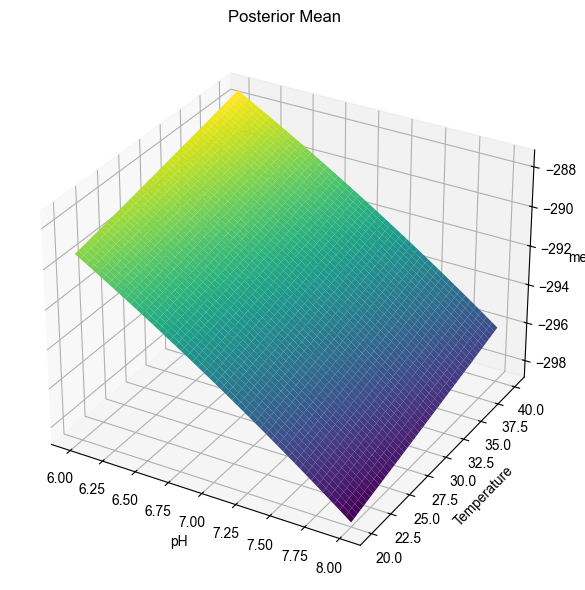

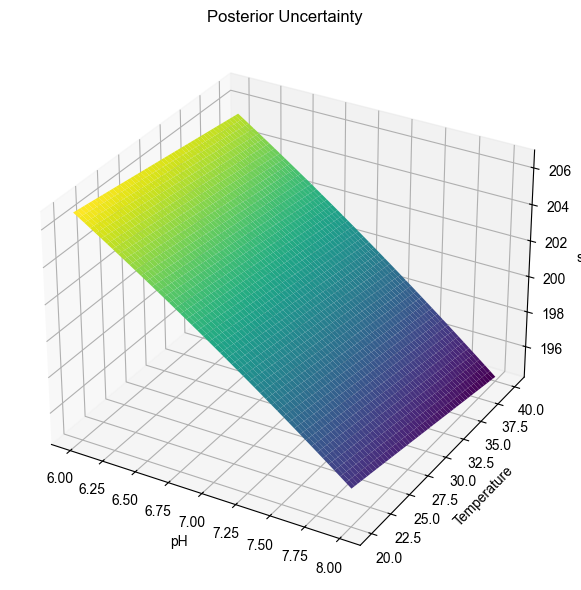

Training with FIXED noise: 1.0% of mean output.
Candidates (normalized): tensor([[0., 1.]], dtype=torch.float64)
Candidates (raw): tensor([[ 6., 40.]], dtype=torch.float64)
Iteration 2:
  Candidate (raw): tensor([[ 6., 40.]], dtype=torch.float64)
  Predicted mean: -323.8698
  Predicted std:  219.7134
  New y:          56.5410


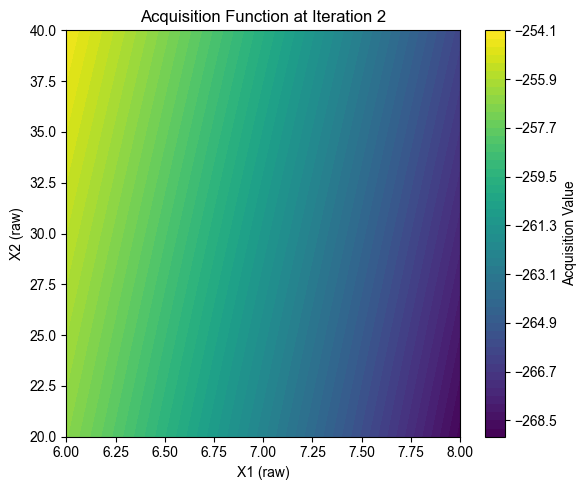

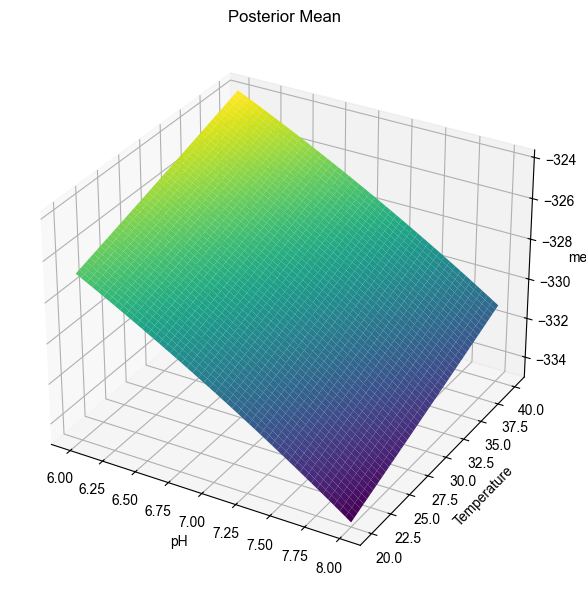

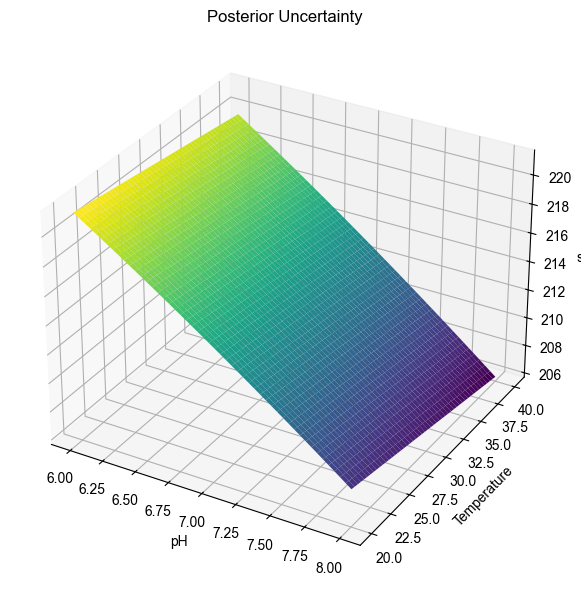

Training with FIXED noise: 1.0% of mean output.
Candidates (normalized): tensor([[0., 1.]], dtype=torch.float64)
Candidates (raw): tensor([[ 6., 40.]], dtype=torch.float64)
Iteration 3:
  Candidate (raw): tensor([[ 6., 40.]], dtype=torch.float64)
  Predicted mean: -336.4643
  Predicted std:  222.9287
  New y:          56.5410


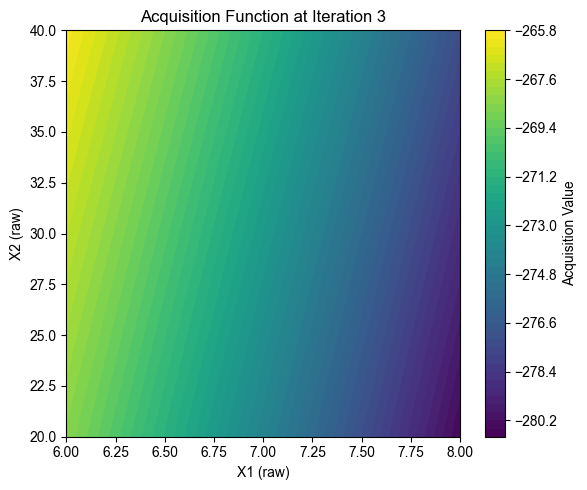

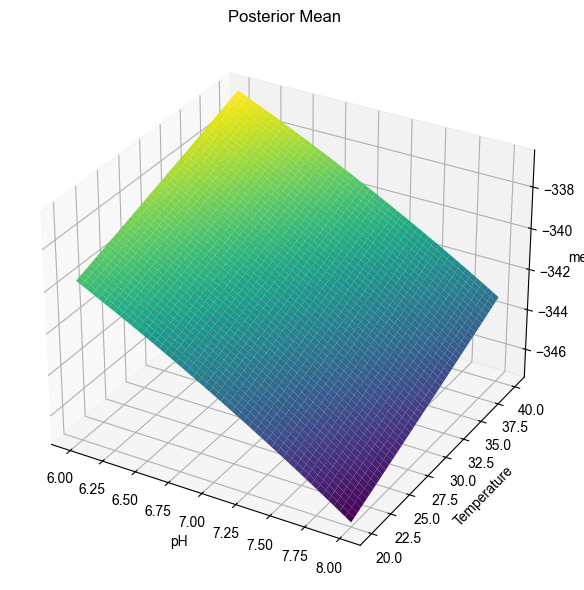

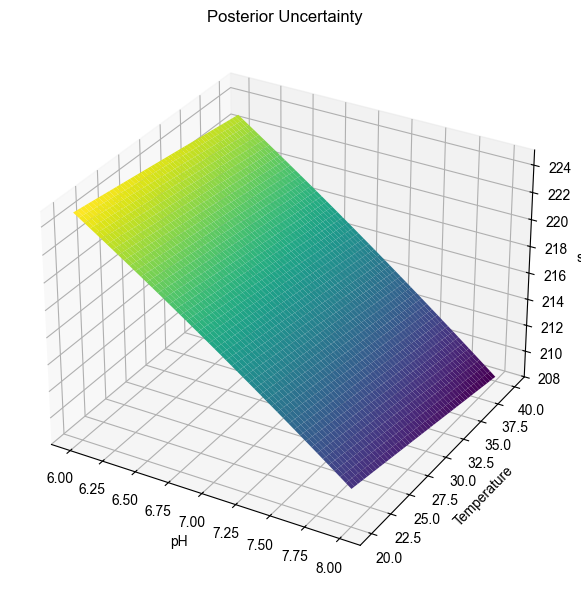

Training with FIXED noise: 1.0% of mean output.
Candidates (normalized): tensor([[0., 1.]], dtype=torch.float64)
Candidates (raw): tensor([[ 6., 40.]], dtype=torch.float64)
Iteration 4:
  Candidate (raw): tensor([[ 6., 40.]], dtype=torch.float64)
  Predicted mean: -349.6981
  Predicted std:  226.1998
  New y:          56.5410


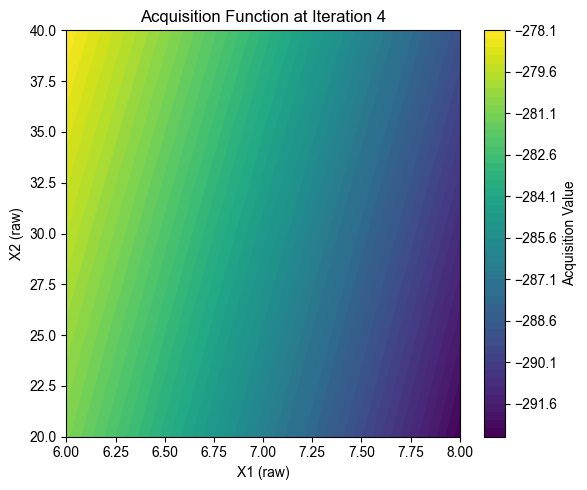

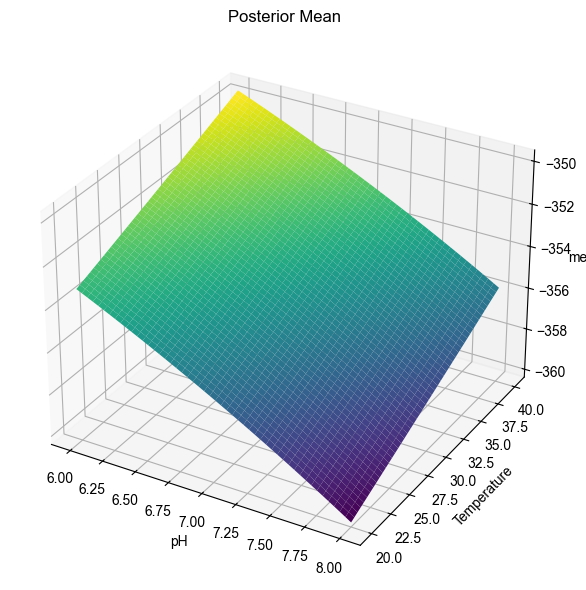

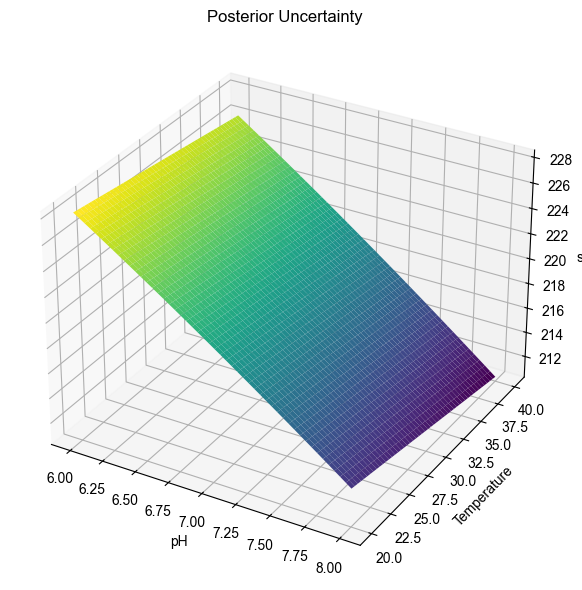

Training with FIXED noise: 1.0% of mean output.
Candidates (normalized): tensor([[0., 1.]], dtype=torch.float64)
Candidates (raw): tensor([[ 6., 40.]], dtype=torch.float64)
Iteration 5:
  Candidate (raw): tensor([[ 6., 40.]], dtype=torch.float64)
  Predicted mean: -363.5559
  Predicted std:  229.5514
  New y:          56.5410


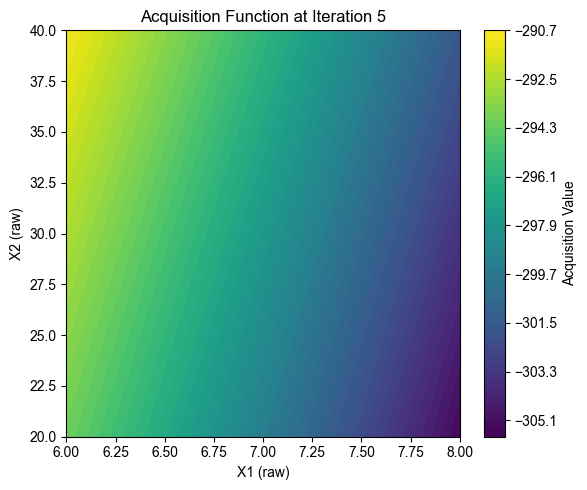

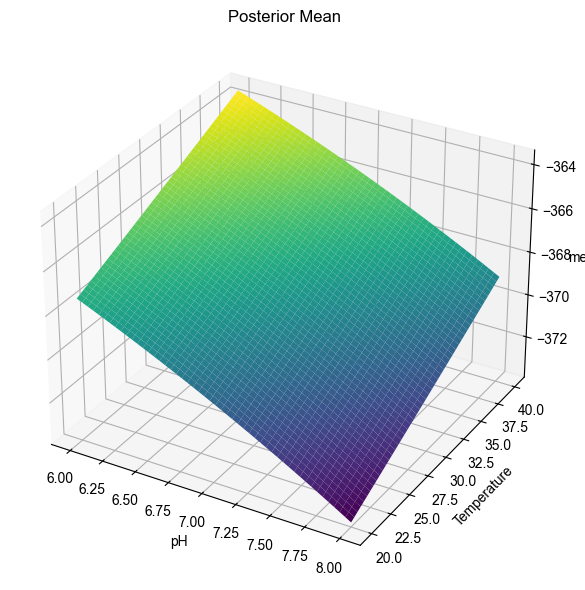

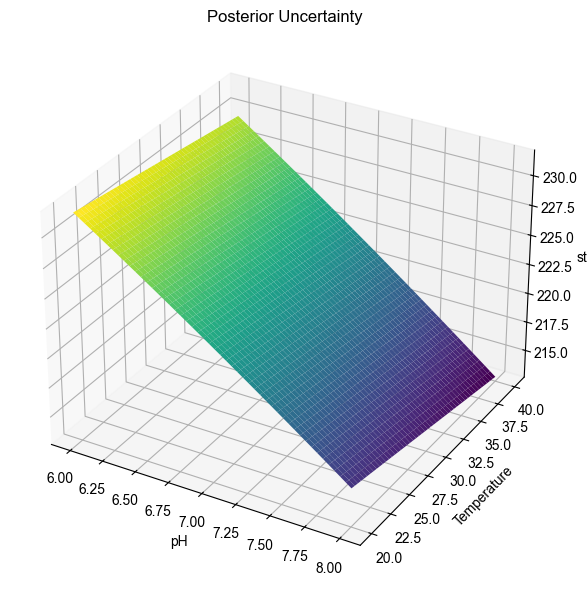

Training with FIXED noise: 1.0% of mean output.
Candidates (normalized): tensor([[0., 1.]], dtype=torch.float64)
Candidates (raw): tensor([[ 6., 40.]], dtype=torch.float64)
Iteration 6:
  Candidate (raw): tensor([[ 6., 40.]], dtype=torch.float64)
  Predicted mean: -378.2376
  Predicted std:  232.9306
  New y:          56.5410


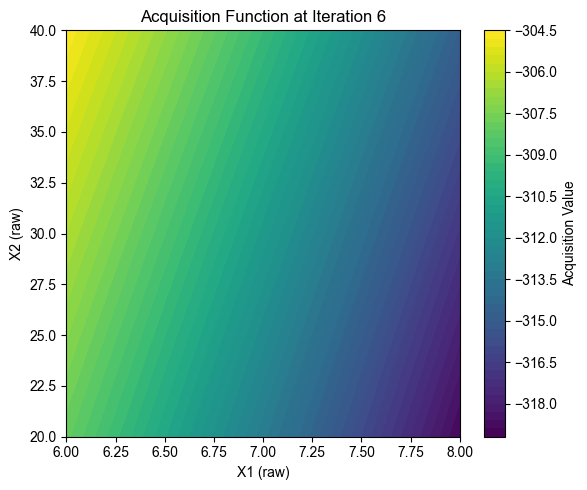

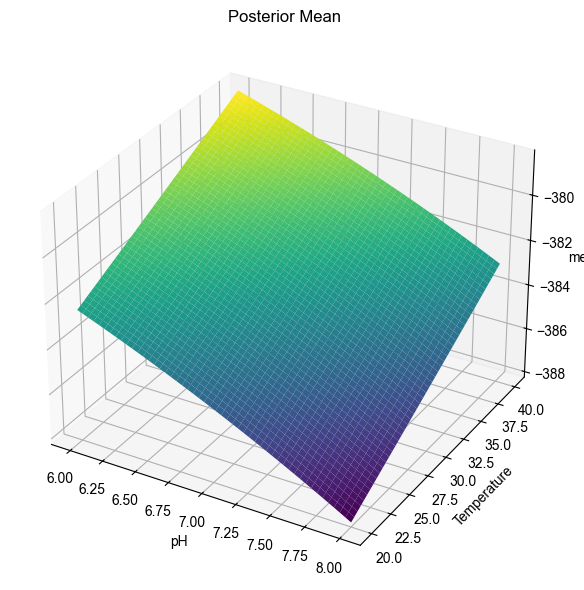

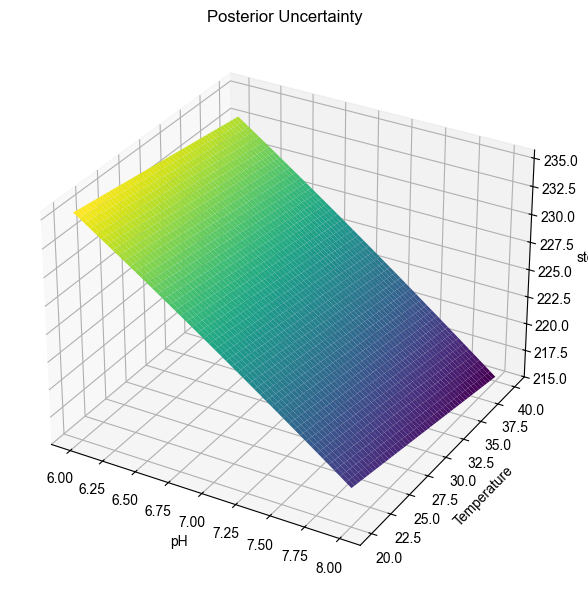

noise 3.6911747763139155e-05
Lengthscales: tensor([[3.4928, 1.7768]], grad_fn=<SoftplusBackward0>)
Outputscale: tensor(23.1775, grad_fn=<SoftplusBackward0>)
Max predicted mean: 98.20499651026608


In [179]:
# ===========================
# BO Loop
# ===========================

normalized_bounds = torch.stack([torch.zeros(bounds.shape[1], dtype=bounds.dtype), 
                                 torch.ones(bounds.shape[1], dtype=bounds.dtype)
                                ])
n_iterations =6
num_restarts = 5

for iteration in range(n_iterations):
    # Train model
    model, mll = train_GP_model(train_X, train_Y, fixed_noise=True)
    '''
    # Recompute batch_initial_conditions each iteration (important!)
    X_normalized = normalize(train_X, bounds)
    topk = torch.topk(train_Y.squeeze(), k=num_restarts, largest=True)
    batch_initial_conditions = X_normalized[topk.indices].unsqueeze(1)
    '''
    # Acquisition function (try switching between UCB and qLogNEI to compare)
    # acq_func = qLogNoisyExpectedImprovement(model=model,X_baseline=train_X) # qLogNEI
    # Alternative (exploratory):
    acq_func = UpperConfidenceBound(model=model, beta=0.1)
    #acq_func = LogExpectedImprovement(model=model, best_f=best_f, maximize=True) # maximize=True for maximization problem
    #acq_func = qUpperConfidenceBound(model=model, beta=0.1) # qUCB
    #acq_func = qLogNoisyExpectedImprovement(model=model, X_baseline = X_normalized) # qLogEI
    #acq_func = qLogNoisyExpectedImprovement(model=model, best_f=best_f, maximize=True, noise_level=noise_level, num_samples=1000, num_fantasies=5, num_restarts=10, raw_samples=True, return_best_only=True) # qLogEI with noise level and num_samples and num_fantasies and num_restarts and raw_samples and return_best_only
    
    # Optimize acquisition function
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=normalized_bounds,
        q=1,
        num_restarts=num_restarts,
        raw_samples=20,
    )

    # Unnormalize candidate
    candidate_raw = unnormalize(candidate, bounds=bounds)

    print("Candidates (normalized):", candidate)
    print("Candidates (raw):", candidate_raw)

    # Evaluate objective
    new_y = objective_function(candidate_raw, seed=seed)
    train_X = torch.cat([train_X, candidate_raw], dim=0)
    train_Y = torch.cat([train_Y, new_y.unsqueeze(-1)], dim=0)

    # Posterior info
    posterior = model.posterior(candidate)
    print(f"Iteration {iteration + 1}:")
    print(f"  Candidate (raw): {candidate_raw}")
    print(f"  Predicted mean: {posterior.mean.item():.4f}")
    print(f"  Predicted std:  {posterior.variance.sqrt().item():.4f}")
    print(f"  New y:          {new_y.item():.4f}")

    # Optional: Plot acquisition function
    plot_acquisition(acq_func, bounds, title=f"Acquisition Function at Iteration {iteration+1}")
    plot_gp_surface(model, bounds, plot_type="mean", title="Posterior Mean")
    plot_gp_surface(model, bounds, plot_type="std", title="Posterior Uncertainty")

    plt.show()

print("noise", model.likelihood.noise_covar.noise.max().item())
print("Lengthscales:", model.covar_module.base_kernel.lengthscale)
print("Outputscale:", model.covar_module.outputscale)
print("Max predicted mean:", model.posterior(train_X).mean.max().item())

    

   


In [88]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import griddata

def summarize_gp_model(model, X_train, X_test=None, save_csv=False, csv_path="gp_diagnostics.csv"):
    model.eval()
    with torch.no_grad():
        posterior = model(X_train)
        mean = posterior.mean
        stddev = posterior.variance.sqrt()

    # Extract parameters
    lengthscale = model.covar_module.base_kernel.lengthscale.detach().cpu().numpy()
    outputscale = model.covar_module.outputscale.detach().cpu().numpy()
    noise = model.likelihood.noise.detach().cpu().numpy()

    # Print diagnostics
    print("=== GP Model Diagnostics ===")
    print("ARD Lengthscales:", lengthscale)
    print("Outputscale:", outputscale)
    print("Noise:", noise)
    print("Predictive Mean (first 5):", mean[:5].squeeze().cpu().numpy())
    print("Predictive StdDev (first 5):", stddev[:5].squeeze().cpu().numpy())

    # === 2D Visualization ===
    if X_train.shape[1] == 2:
        x = X_train[:, 0].cpu().numpy()
        y = X_train[:, 1].cpu().numpy()
        z = mean.squeeze().cpu().numpy()
        err = stddev.squeeze().cpu().numpy()

        # Predictive mean scatter
        plt.figure(figsize=(6, 5))
        sc = plt.scatter(x, y, c=z, cmap='viridis', s=60, edgecolor='k')
        plt.colorbar(sc, label="Predictive Mean")
        plt.xlabel("Input dim 0")
        plt.ylabel("Input dim 1")
        plt.title("Predictive Mean at Training Points")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Predictive stddev scatter
        plt.figure(figsize=(6, 5))
        sc = plt.scatter(x, y, c=err, cmap='plasma', s=60, edgecolor='k')
        plt.colorbar(sc, label="Predictive Stddev")
        plt.xlabel("Input dim 0")
        plt.ylabel("Input dim 1")
        plt.title("Predictive Uncertainty at Training Points")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # === Optional: grid-based contour ===
        if X_test is not None:
            model.eval()
            with torch.no_grad():
                test_posterior = model(X_test)
                test_mean = test_posterior.mean.cpu().numpy()
                test_stddev = test_posterior.variance.sqrt().cpu().numpy()

            xg = X_test[:, 0].cpu().numpy()
            yg = X_test[:, 1].cpu().numpy()
            zg = test_mean.squeeze()
            errg = test_stddev.squeeze()

            # Interpolate for contour plot
            xi = np.linspace(xg.min(), xg.max(), 100)
            yi = np.linspace(yg.min(), yg.max(), 100)
            Xi, Yi = np.meshgrid(xi, yi)
            Zi = griddata((xg, yg), zg, (Xi, Yi), method='cubic')
            Ei = griddata((xg, yg), errg, (Xi, Yi), method='cubic')

            # Contour plot for predictive mean
            plt.figure(figsize=(6, 5))
            cs = plt.contourf(Xi, Yi, Zi, cmap='viridis')
            plt.colorbar(cs, label="Predictive Mean")
            plt.xlabel("Input dim 0")
            plt.ylabel("Input dim 1")
            plt.title("GP Predictive Mean (Interpolated)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Contour plot for stddev
            plt.figure(figsize=(6, 5))
            cs = plt.contourf(Xi, Yi, Ei, cmap='plasma')
            plt.colorbar(cs, label="Predictive Stddev")
            plt.xlabel("Input dim 0")
            plt.ylabel("Input dim 1")
            plt.title("GP Predictive Uncertainty (Interpolated)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        print("2D visualization skipped: input is not 2D.")

    # Bar plot of inverse lengthscales
    inv_lengthscale = 1.0 / lengthscale
    norm_inv_lengthscale = inv_lengthscale / inv_lengthscale.sum()

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(norm_inv_lengthscale[0])), norm_inv_lengthscale[0])
    plt.title("Normalized Inverse Lengthscales (Feature Importance)")
    plt.xlabel("Input Dimension")
    plt.ylabel("Relative Importance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save to CSV
    if save_csv:
        df = pd.DataFrame({
            "lengthscale": lengthscale[0],
            "inv_lengthscale": inv_lengthscale[0],
            "norm_inv_lengthscale": norm_inv_lengthscale[0],
            "outputscale": [outputscale] * len(lengthscale[0]),
            "noise": [noise] * len(lengthscale[0]),
        })
        df.to_csv(csv_path, index=False)
        print(f"Diagnostics saved to {csv_path}")

    return {
        "lengthscale": lengthscale,
        "outputscale": outputscale,
        "noise": noise,
        "mean": mean.cpu().numpy(),
        "stddev": stddev.cpu().numpy()
    }


=== GP Model Diagnostics ===
ARD Lengthscales: [[0.08577251 0.28116983]]
Outputscale: 0.6613886
Noise: [2.87133649e-05 2.87133649e-05 2.87133649e-05 ... 2.87133649e-05
 2.87133649e-05 2.87133649e-05]
Predictive Mean (first 5): [-0.74002188 -0.74002188 -0.74002188 -0.74002188 -0.74002188]
Predictive StdDev (first 5): [0.813258 0.813258 0.813258 0.813258 0.813258]


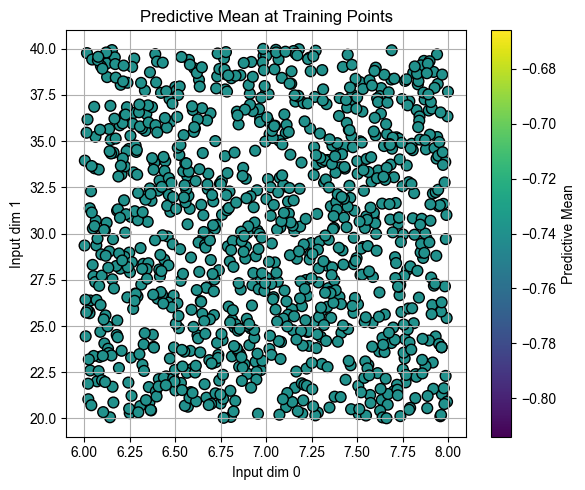

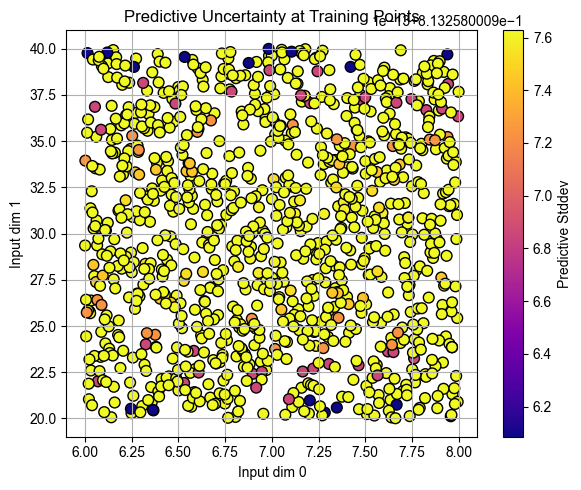

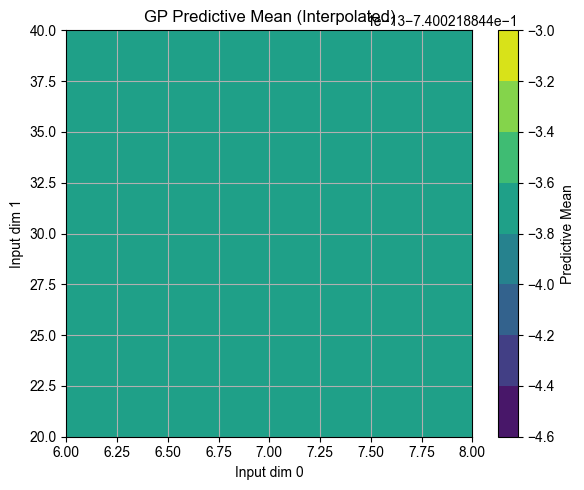

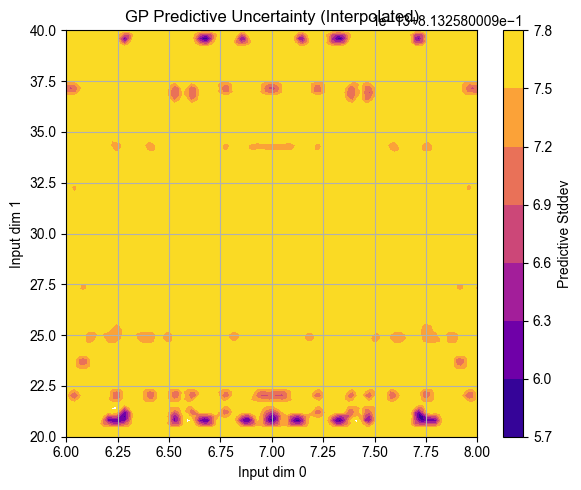

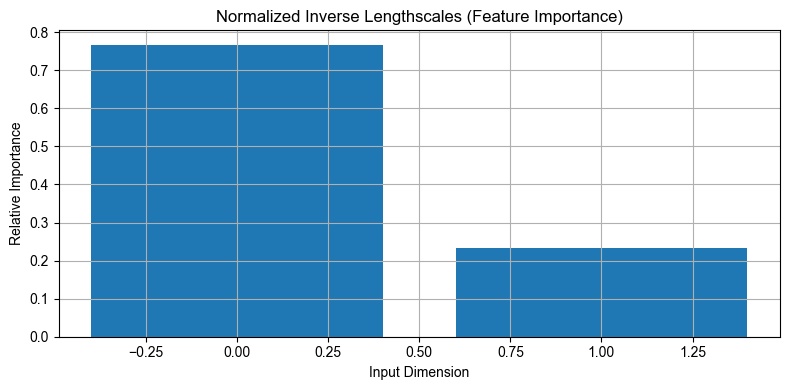

{'lengthscale': array([[0.08577251, 0.28116983]], dtype=float32),
 'outputscale': array(0.6613886, dtype=float32),
 'noise': array([2.87133649e-05, 2.87133649e-05, 2.87133649e-05, ...,
        2.87133649e-05, 2.87133649e-05, 2.87133649e-05], shape=(1005,)),
 'mean': array([-0.74002188, -0.74002188, -0.74002188, ..., -0.74002188,
        -0.74002188, -0.74002188], shape=(1006,)),
 'stddev': array([0.813258, 0.813258, 0.813258, ..., 0.813258, 0.813258, 0.813258],
       shape=(1006,))}

In [167]:
x1 = torch.linspace(6.0, 8.0, 50)
x2 = torch.linspace(20.0, 40.0, 50)
X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
X_test = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

summarize_gp_model(model, train_X, X_test=X_test)


In [73]:
print (posterior.mean.item())

9.604104244381679


In [75]:
candidate_normalized = normalize(candidate_raw, normalized_bounds) #?
posterior = model.posterior(candidate_normalized)
print("Predicted mean at candidate:", posterior.mean.item())
print("Predicted std at candidate:", posterior.variance.sqrt().item())

Predicted mean at candidate: 97.97036274594795
Predicted std at candidate: 0.4154410506317525


In [117]:
print (train_X)
print (train_Y)

tensor([[ 7.4452, 36.8180],
        [ 7.2647, 25.2413],
        [ 7.8008, 34.8602],
        ...,
        [ 7.4583, 35.5959],
        [ 8.0000, 40.0000],
        [ 8.0000, 40.0000]], dtype=torch.float64)
tensor([[69.6262],
        [-0.3652],
        [76.5475],
        ...,
        [94.1708],
        [70.4100],
        [70.4100]], dtype=torch.float64)


In [49]:
pH_opt, temp_opt, a, b, c, iterations, starting_replicates, replicate_list = 7, 35, 100, 20, 1, 3, 24, [6, 6, 6]
def plot_protein_production(train_X, train_Y, pH_opt, temp_opt, a, b, c, iterations, starting_replicates,replicate_list):#, cmap='Blues'):
    plt.rcParams.update({'font.size': 10, 'font.family': 'Arial'})
    fontsize = 10
    
    # Prepare data
    exp_data2 = np.column_stack((train_X, train_Y))
    x, y, z = exp_data2[:, 0], exp_data2[:, 1], exp_data2[:, 2]
    
    pH_values = np.linspace(min(x), max(x), 100)
    temp_values = np.linspace(min(y), max(y), 100)
    pH_grid, temp_grid = np.meshgrid(pH_values, temp_values)
    
    pH_tensor = torch.tensor(pH_grid, dtype=torch.double)
    temp_tensor = torch.tensor(temp_grid, dtype=torch.double)

    Z = a - b*(pH_tensor-pH_opt)**2 - c*(temp_tensor-temp_opt)**2
    Z = Z + 0.05 * torch.randn_like(Z)
    # -----------------------
    fig = plt.figure(figsize=(10, 5))
    
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(pH_grid, temp_grid, Z, cmap='Blues')
    ax.set_xlabel('pH')
    ax.set_ylabel('Temperature')
    ax.set_zlabel('Protein Titer (g/L)')
    
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(pH_grid, temp_grid, Z, levels=10, cmap='Blues')
    cbar = fig.colorbar(contour, ax=ax2, shrink=0.5)
    ax2.set_xlabel('pH')
    ax2.set_ylabel('Temperature')
    cbar.set_label("Protein Titer (g/L)")
    
    colors = plt.cm.Reds(np.linspace(0, 1, iterations+1)) # create the need number of colors
    # print(colors) 
    # point_colors = [colors[i // replicates % len(colors)] for i in range(len(x))]
    # Flatten replicate counts to map each experiment to a color
    point_colors = []
    color_idx = 0  # Track color index corresponding to iterations

    # Handle the starting set separately
    for _ in range(starting_replicates):
        point_colors.append(colors[color_idx])  # Assign 0th iteration color

    color_idx += 1  # Move to the next color

    # Assign colors for the remaining iterations
    for i, rep in enumerate(replicate_list):
        for _ in range(rep):
            point_colors.append(colors[color_idx])  # Assign color for this iteration
        color_idx += 1  # Move to the next iteration’s color
    
    print(len(point_colors))
    print(x.shape)


    color_labels = [f"Iter. {i}" for i in range(iterations+1)]
    
    for i in range(len(x)):
        ax2.scatter(x[i], y[i], color=point_colors[i], edgecolor='black', s=80)
    
    fig.subplots_adjust(left=0.1, right=.78, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    
    scatter_legend = ax2.legend(
        handles=[mpatches.Patch(color=color, label=label) for color, label in zip(colors, color_labels)],
        title="Experiments",
        bbox_to_anchor=(1.03, 1), loc="upper left", borderaxespad=0
    )
    
    ax2.add_artist(scatter_legend)
    cbar.ax.set_position([0.75, 0.1, 0.1, 0.5])
    plt.show()
    return fig

42
(44,)


IndexError: list index out of range

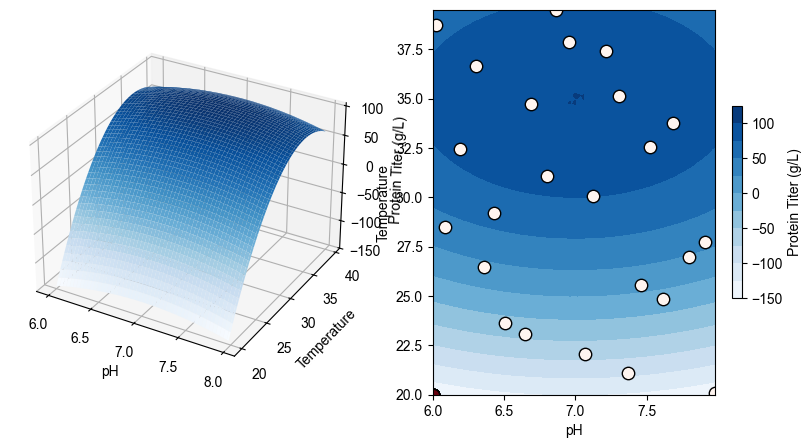

In [100]:
fig = plot_protein_production(train_X, train_Y, pH_opt, temp_opt, a, b, c, iterations, starting_replicates, replicate_list)

In [22]:
fig_1 = plot_protein_production(train_X_list[0], train_Y_list[0], pH_opt, temp_opt, a, b, c, iterations, starting_replicates,replicate_list)

NameError: name 'train_X_list' is not defined

Lengthscale: [[1.6113575e+04 5.9522879e-01]]
Noise: [0.00935322]
Mean: -1.011914
Predictive mean: tensor([-1.0119, -1.0119, -1.0119, -1.0119, -1.0119], dtype=torch.float64)
Predictive stddev: tensor([1.2234, 1.2234, 1.2234, 1.2234, 1.2234], dtype=torch.float64)


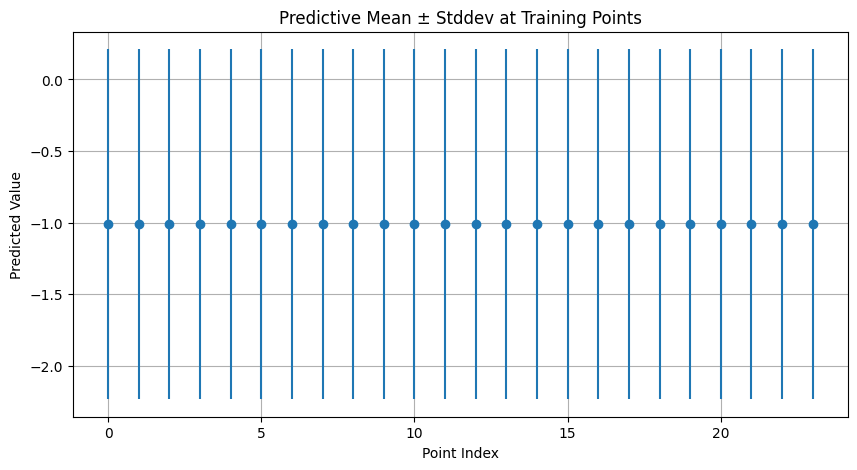

In [ ]:
print("Lengthscale:", model_prior.covar_module.base_kernel.lengthscale.detach().numpy())
print("Noise:", model_prior.likelihood.noise.detach().numpy())
print("Mean:", model_prior.mean_module.constant.detach().numpy())
'''
print("Raw lengthscale:", model.covar_module.raw_lengthscale)
print("Raw noise:", model.likelihood.raw_noise)
print("Raw mean constant:", model.mean_module.raw_constant)
'''
model_prior.eval()
with torch.no_grad():
    posterior = model_prior(train_X)  # or some test_X
    mean = posterior.mean
    stddev = posterior.variance.sqrt()  # standard deviation (uncertainty)

print("Predictive mean:", mean[:5].squeeze())
print("Predictive stddev:", stddev[:5].squeeze())

plt.figure(figsize=(10, 5))
plt.errorbar(range(len(mean)), mean.squeeze(), yerr=stddev.squeeze(), fmt='o')
plt.title("Predictive Mean ± Stddev at Training Points")
plt.xlabel("Point Index")
plt.ylabel("Predicted Value")
plt.grid(True)
plt.show()


In [ ]:
lengthscales = model_prior.covar_module.base_kernel.lengthscale.detach().numpy()
print("Lengthscales (ARD):", lengthscales)

for i, ls in enumerate(lengthscales.squeeze()):
    print(f"Lengthscale dim {i}: {ls:.4f}")

outputscale = model_prior.covar_module.outputscale.detach().numpy()
print("Outputscale:", outputscale)

Lengthscales (ARD): [[1.6113575e+04 5.9522879e-01]]
Lengthscale dim 0: 16113.5752
Lengthscale dim 1: 0.5952
Outputscale: 1.4966396


In [ ]:
#Final clean version, above are tests and checks

print("\n=== GP Model Parameters ===")
print("Mean:", model_prior.mean_module.constant.item())
print("Noise (learned):", model_prior.likelihood.noise.item())
print("Outputscale:", model_prior.covar_module.outputscale.item())

lengthscales = model_prior.covar_module.base_kernel.lengthscale.detach().squeeze()
print("Lengthscales (ARD):", lengthscales.numpy())
for i, ls in enumerate(lengthscales):
    print(f"  Dim {i+1} lengthscale: {ls:.4f}")


=== GP Model Parameters ===
Mean: -1.0119140148162842
Noise (learned): 0.009353224089784088
Outputscale: 1.496639609336853
Lengthscales (ARD): [1.6113575e+04 5.9522879e-01]
  Dim 1 lengthscale: 16113.5752
  Dim 2 lengthscale: 0.5952
